In [1]:
import pickle, os
import networkx as nx

In [2]:
#Load and build graph
with open('./processed_data/connectivity.pkl', 'rb') as handle:
    France = pickle.load(handle)
    
France = nx.Graph(France)

In [3]:
#Load and add attributes dict
with open('./processed_data/departments.pkl', 'rb') as handle:
    France_atts = pickle.load(handle)

In [4]:
#Set department name
nx.set_node_attributes(France,
            {key:value['name'] for key, value in France_atts.items()},
            'name')

In [5]:
#Set department coordinates
nx.set_node_attributes(France,
            {key:value['capital_coords'] for key, value in France_atts.items()},
            'coords')

In [6]:
#Set department capital
nx.set_node_attributes(France,
            {key:value['capital'] for key, value in France_atts.items()},
            'capital')

In [7]:
#Set department population
nx.set_node_attributes(France,
            {key:value['population'] for key, value in France_atts.items()},
            'population')

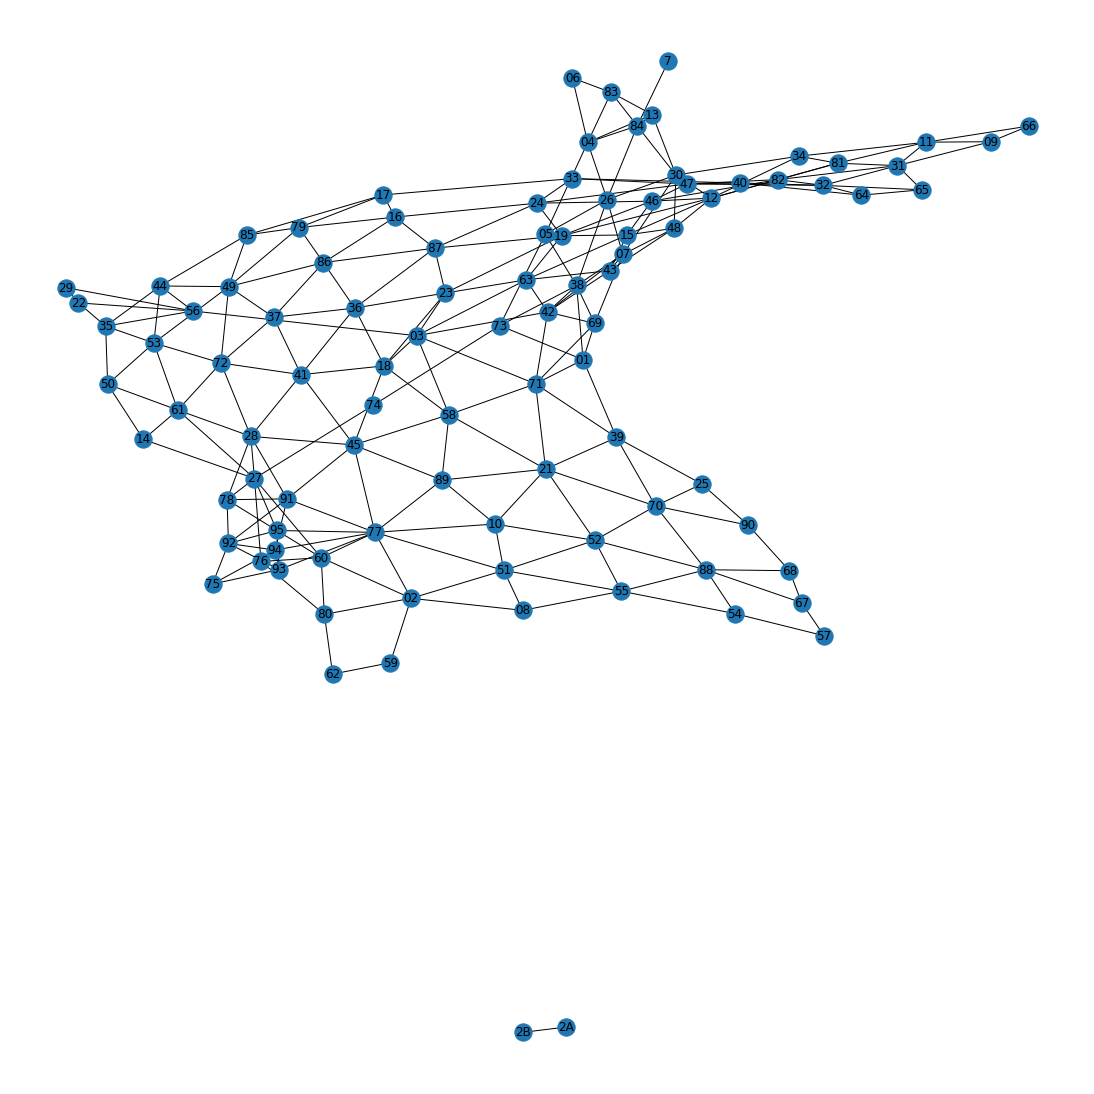

In [136]:
nx.draw(France, with_labels=True)

In [9]:
#Save pickle
#nx.write_gpickle(France, path='./processed_data/France_graph.pkl')

In [10]:
#Save GML graph
#nx.write_gml(France, path='./processed_data/France_graph.gml')

# Network visualizations using basemap

In [121]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.feature import NaturalEarthFeature, COLORS

In [197]:
pos = {key:tuple([i for i in val['capital_coords'].values()][::-1]) for key,val in France_atts.items()}

In [144]:
France.remove_node('7')

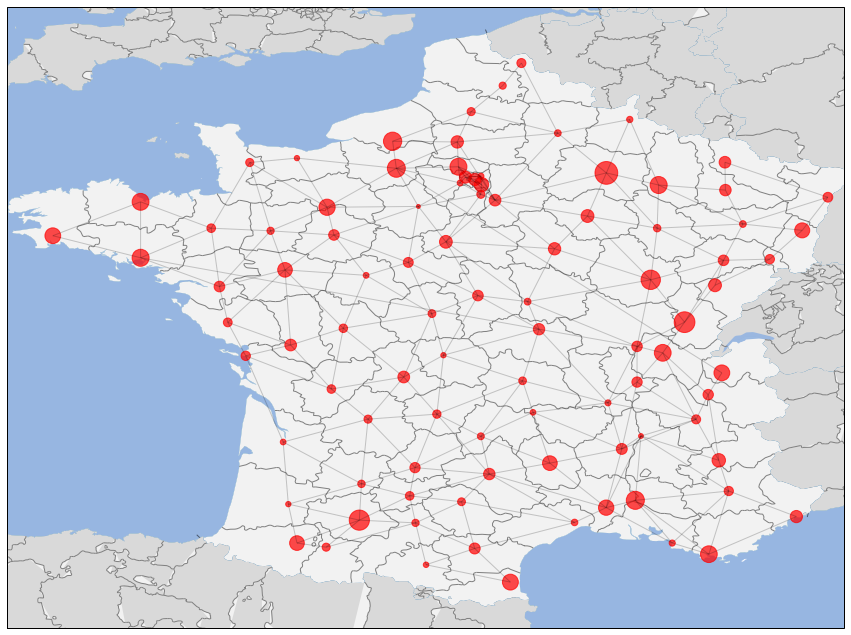

In [217]:
def main():
    
    #####  MAP  #####
    
    shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
                 
    ax.set_global()
    ax.set_extent([-4.8, 8, 42, 51.5], ccrs.Geodetic())
    
    land = NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor=COLORS['land'])
    ocean = NaturalEarthFeature(category='physical', name='ocean',
                            scale='10m', facecolor=COLORS['water'])
    coastline = NaturalEarthFeature(category='physical', name='coastline',
                            scale='10m')
    lakes     = NaturalEarthFeature(category='physical', name='lakes',
                            scale='10m', facecolor=COLORS['water'])
    states    = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines',
                                    edgecolor='gray', facecolor=(0.95, 0.95, 0.95), scale='10m')
    
    ax.add_feature(ocean)
    ax.add_feature(land)
    ax.add_feature(coastline)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5, )
        
    for country in countries:
        if country.attributes['SOVEREIGNT'] == "France":
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor=(0.95, 0.95, 0.95))
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), facecolor=(0.85, 0.85, 0.85))
            
    ax.add_feature(lakes, alpha=0.95)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.add_feature(states)
    
    ##### GRAPH #####
    
    nodes = nx.draw_networkx_nodes(G = France, pos = pos, 
                           node_list = France.nodes(), node_color = 'r',
                           alpha = 0.7, node_size = [i['population']/5000 for i in France_atts.values()], ax=ax) 
    edges = nx.draw_networkx_edges(G = France, pos = pos, edge_color='black',
                           alpha=0.2, arrows = False, ax=ax)
    
    nodes.set_zorder(20)
    edges.set_zorder(20)
    
    ##### SETUP #####
    
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()


if __name__ == '__main__':
    main()